# Imports

In [1]:
from pathlib import Path
from importlib import reload
import os
import sys
import json
from tqdm.auto import tqdm
import shutil
from multiprocessing import Pool
from IPython.display import clear_output
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

import numpy as np

import scipy.signal
import scipy.ndimage
from scipy.fft import fft, fftfreq

import yt

import lib
reload(lib)
import lib

# === Module config ===
yt.funcs.mylog.setLevel(50)

# Common styling for all plots
RCPARAMS = {
    "axes.formatter.use_mathtext": True,
    "axes.titleweight": "bold",
    "axes.labelweight": "bold",
    "axes.grid": False,
    "errorbar.capsize": 0.0,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 20,
    "text.usetex": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "legend.borderpad": 0.2,
    "legend.borderaxespad": 0.0,
    "legend.edgecolor": 'black',
    "legend.fancybox": False,
    "legend.framealpha": 1.0,
    "legend.handlelength": 2.0,
    "legend.handletextpad": 0.3,
    "lines.linewidth": 2.0,
}
plt.rcParams.update(RCPARAMS)

# Utilities

In [2]:
X_CATHODE_MM = 24.0
X_IZ_MIN_MM = 2.5
X_IZ_MAX_MM = 10.0

In [3]:
FIG_DIR = Path("figures")
FIG_DPI = 200

def save_and_close(fig, name, show=True):
    os.makedirs(FIG_DIR, exist_ok=True)
    fig.savefig(FIG_DIR / f"{name}.png", dpi=FIG_DPI)
    fig.savefig(FIG_DIR / f"{name}.pdf")
    plt.show(fig)
    plt.close(fig)

# Data extraction and processing

In [4]:
def analyze_sim_fields(sim_dir: Path, start_index=0, stop_index=None):
    # Find field dir and create output dir for processed/extracted data
    print(sim_dir, flush=True)
    field_dir = Path(sim_dir) / "fields"
    processed_dir = Path(sim_dir) / "processed"
    if field_dir.exists():
        os.makedirs(processed_dir, exist_ok = True)
    else:
        raise FileNotFoundError(f"{field_dir} does not exist.")

    # Load all field files and sort by iteration
    field_files = os.listdir(field_dir)
    numbers = [int(f.split("_")[1]) for f in field_files] 
    field_files = [f for (f, num) in sorted(zip(field_files, numbers), key = lambda x: x[1])]
    numbers.sort()

    scale_by_c = lambda field: lambda x: x.load2D(field) * lib.c

    # Define fields we want to extract and how to get them
    fields = {
        "Ex": dict(name = "Axial electric field [kV/m]"),
        "Ez": dict(name = "Azimuthal electric field [kV/m]"),
        "ni": dict(
            name = "Ion density [m$^{-3}$]",
            loader = lambda x: x.load2D("rho_ions") / lib.q_e,
        ),
        "ne": dict(
            name = "Electron density [m$^{-3}$]",
            loader = lambda x: x.load2D("rho_electrons") / -lib.q_e,
        ),
        "nn": dict(
            name = "Neutral density [m$^{-3}$]",
            loader = lambda x: x.load2D("n_neutrals"),
        ),
        "Te": dict(
            name = "Electron temperature [eV]",
            loader = lambda x: x.compute_temp("electrons", dimension=2)[0],
        ),
        "ux_ions": dict(name = "Axial ion velocity [m/s]", loader = scale_by_c("ux_ions")),
        "uz_ions": dict(name = "Azimuthal ion velocity [m/s]", loader = scale_by_c("uz_ions")),
        "ux_electrons": dict(name = "Axial electron velocity [m/s]", loader = scale_by_c("ux_electrons")),
        "uz_electrons": dict(name = "Azimuthal electron velocity [m/s]", loader = scale_by_c("uz_electrons")),
        "ux_neutrals": dict(name = "Axial neutral velocity [m/s]", loader = scale_by_c("ux_neutrals")),
        "uz_neutrals": dict(name = "Azimuthal neutral velocity [m/s]", loader = scale_by_c("uz_neutrals")),
        "jx": dict(name = "Axial current density [A/m$^2$]"),
        "jz": dict(name = "Azimuthal current density [A/m$^2$]"),
        "phi": dict(name = "Electrostatic potential [V]"),
        "By": dict(name = "Radial magnetic field [B]"),
    }

    # Extract dt by comparing the times at the first and second simulations
    first_file = lib.GriddedData(field_dir/field_files[0])
    second_file = lib.GriddedData(field_dir/field_files[1])
    dt_s = (second_file.dataset.current_time - first_file.dataset.current_time).value.item()

    # Get grid extent (min and max grid locations in both dimensions
    extent = first_file.extent()
    xmin, xmax, ymin, ymax = [_x.value.item() for _x in extent]

    # Write metadata file for each field of interest
    for field, d in fields.items():
        processed_field_dir = processed_dir / field
        os.makedirs(processed_field_dir, exist_ok=True)
        metadata = dict(xmin_m=xmin, xmax_m=xmax, ymin_m=ymin, ymax_m=ymax, dt_s=dt_s, name=d["name"])
        with open(processed_field_dir/"_metadata.json", "w") as fd:
            json.dump(metadata, fd)

    if stop_index is not None and stop_index < start_index:
        return

    # Set appropriate stop index
    if stop_index is None or stop_index > len(numbers):
        stop_index = len(numbers)

    # Iterate through output files, extract fields, and save to files
    for i in (pbar := tqdm(range(start_index, stop_index))):
        pbar.set_description(str(sim_dir))
        number = numbers[i]
        file = field_files[i]
        data_path = field_dir / file
        dataset = lib.GriddedData(data_path)
    
        for field, d in fields.items():
            loader = d.get("loader", lambda x: x.load2D(field))
            arr = loader(dataset)
            name = d["name"]
            np.save(processed_dir / field / f"{field}_{number:012d}.npy", arr)

    return None

In [5]:
archive_dir = Path("../archive")
sims_to_analyze = [
    #"base_4x_2000K_1",
    #"base_4x_2000K_2",
    #"base_4x_2000K_3",
    #"base_4x_2000K_recombine",
    #"base_2x_2000K_1",
    #"base_2x_2000K_2",
    #"base_2x_2000K_3",
    #"base_2x_2000K_recombine",
    #"base_1x_noneutrals",
    #"base_2x_noneutrals",
    "benchmark_1x",
    #"benchmark_2x",
]
sims_to_analyze = [archive_dir / p for p in sims_to_analyze]

nprocs = 8
stop_index = -1

def f(x):
    analyze_sim_fields(x, stop_index=stop_index)

with Pool(nprocs) as p:
    p.map(f, sims_to_analyze)

../archive/benchmark_1x


In [6]:
def read_metadata(data_dir, field):
    # Read data files
    processed_field_dir = data_dir / field
    assert processed_field_dir.exists()
    array_files = os.listdir(processed_field_dir)
    array_files.sort(key = lambda d: d.replace("_", "}", 1) if d.startswith("_") else d)

    # Read metadata
    assert array_files[-1] == "_metadata.json"
    with open(processed_field_dir / array_files[-1], "r") as fd:
        metadata = json.load(fd)

    xmin, xmax = metadata["xmin_m"], metadata["xmax_m"]
    ymin, ymax = metadata["ymin_m"], metadata["ymax_m"]
    extent = np.array([xmin, xmax, ymin, ymax])
    arr = np.load(processed_field_dir / array_files[0])
    files = [processed_field_dir / f for f in array_files[:-1]]
    
    return dict(
        extent=extent,
        dt=metadata["dt_s"],
        name=metadata["name"],
        shape=arr.shape,
        files=files,
    )

# 2D animations

In [7]:
def animate_quantity_2D(data_dir, output_file, field = "Ez", scale = 1.0, frames=None, **img_kwargs):
    metadata = read_metadata(data_dir, field)
    extent = metadata["extent"] * 1000 # convert to mm
    files = metadata["files"]
    dt = metadata["dt"]
    field_name = metadata["name"]

    fig, ax = plt.subplots(1,1, figsize=(12, 6.5), dpi=200)
    ax.set(xlabel = "Axial position [mm]", ylabel = "Azimuthal position [mm]", title = f"{field_name} (t = 0.0 us)")
    arr = np.load(files[0])
    im = ax.imshow(arr * scale, cmap='RdBu_r', extent = extent, origin = 'lower', **img_kwargs)
    
    # Create axis for colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax, extend = 'both')

    def update(frame):
        # for each frame, update the data stored on each artist.
        arr = np.load(files[frame])
        clear_output(wait=True)
        print(f"{frame=}")
        im.set_data(arr * scale)
        ax.set_title(f"{field_name} ({frame*dt*1e6:.1f} us)")
        return im

    if frames is None:
        frames = range(len(array_files))
    
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=60, repeat=False)
    anim.save(output_file)

frame=399


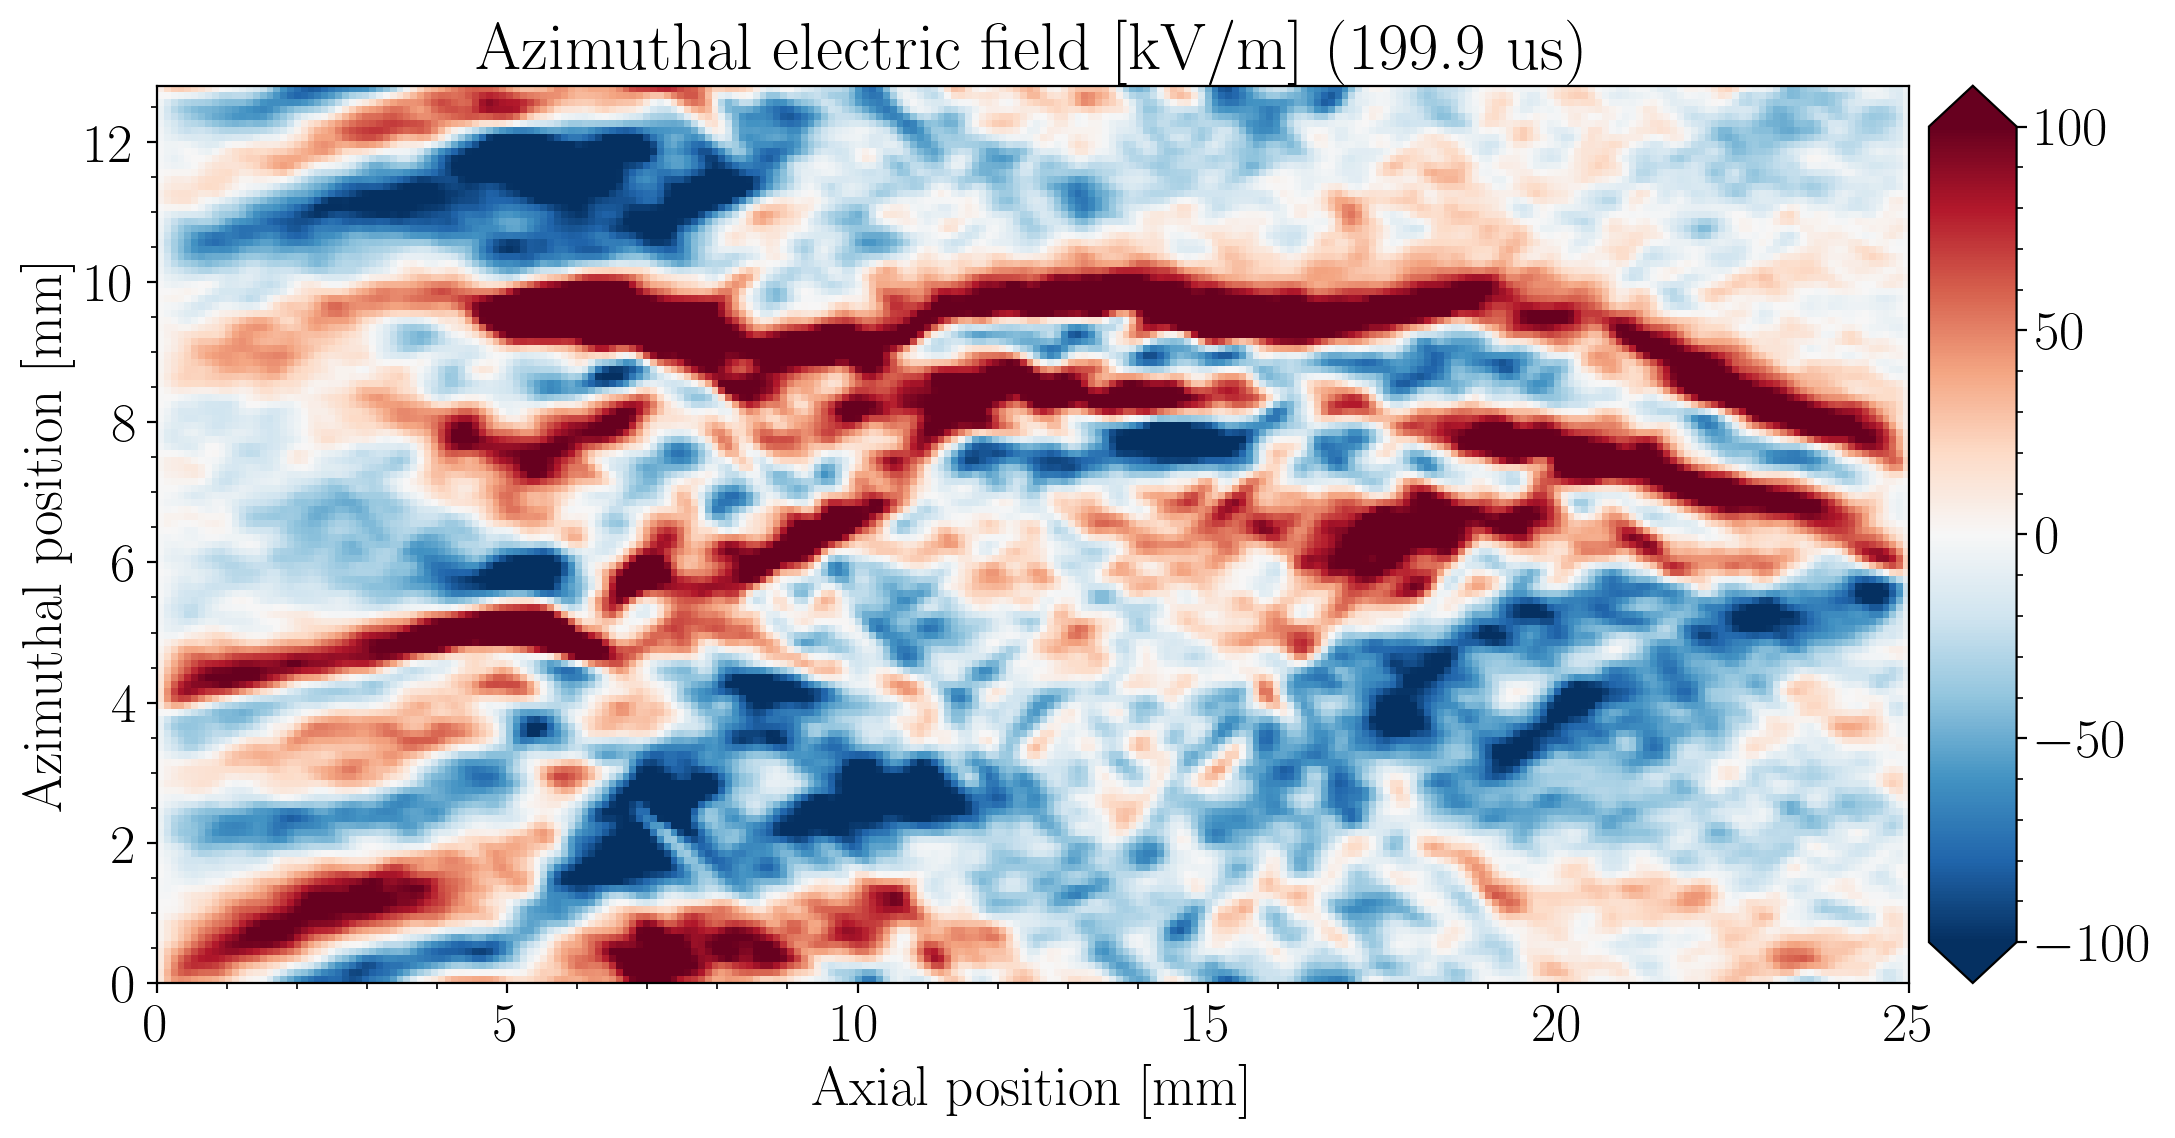

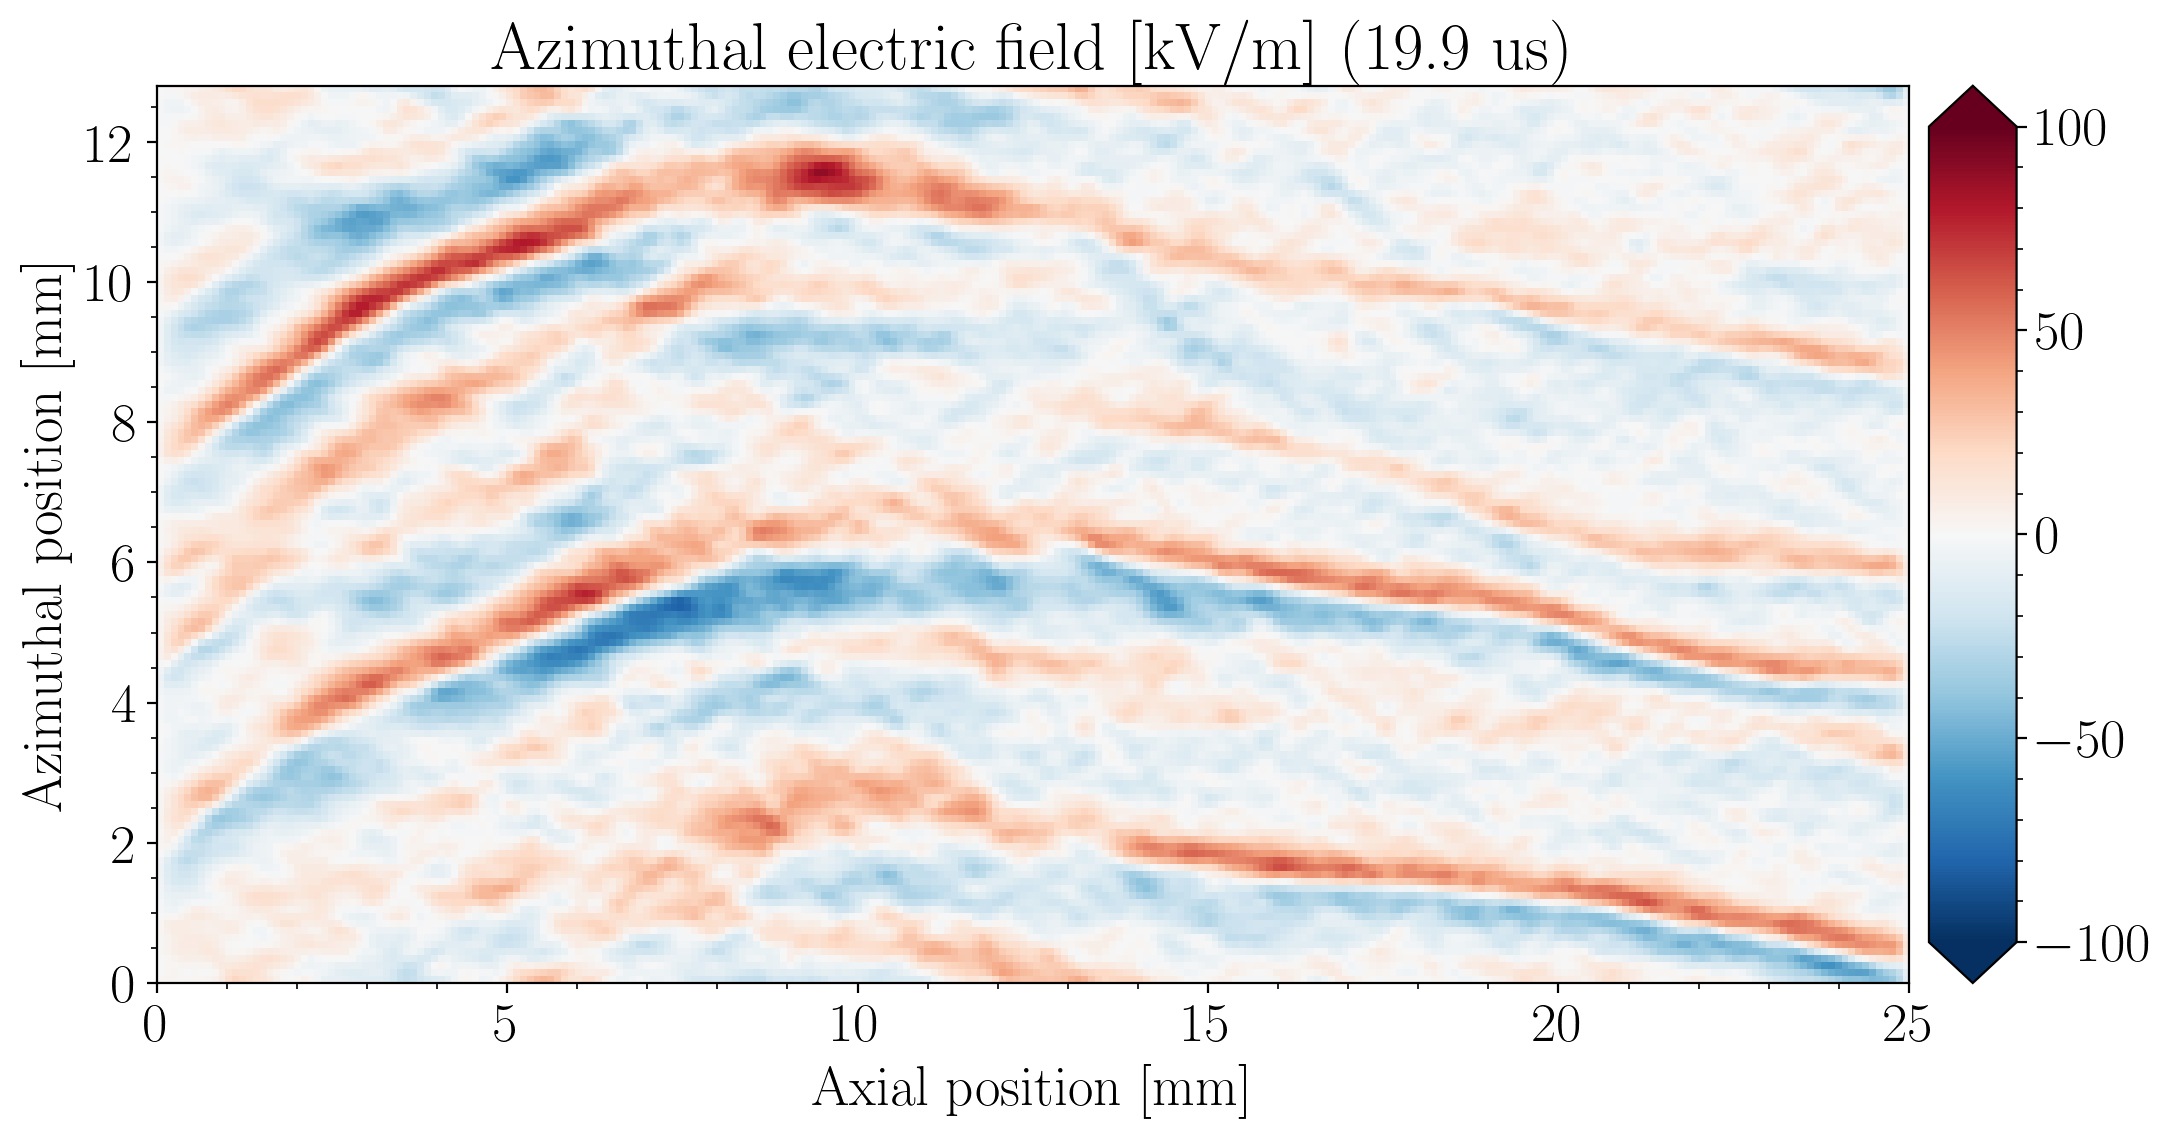

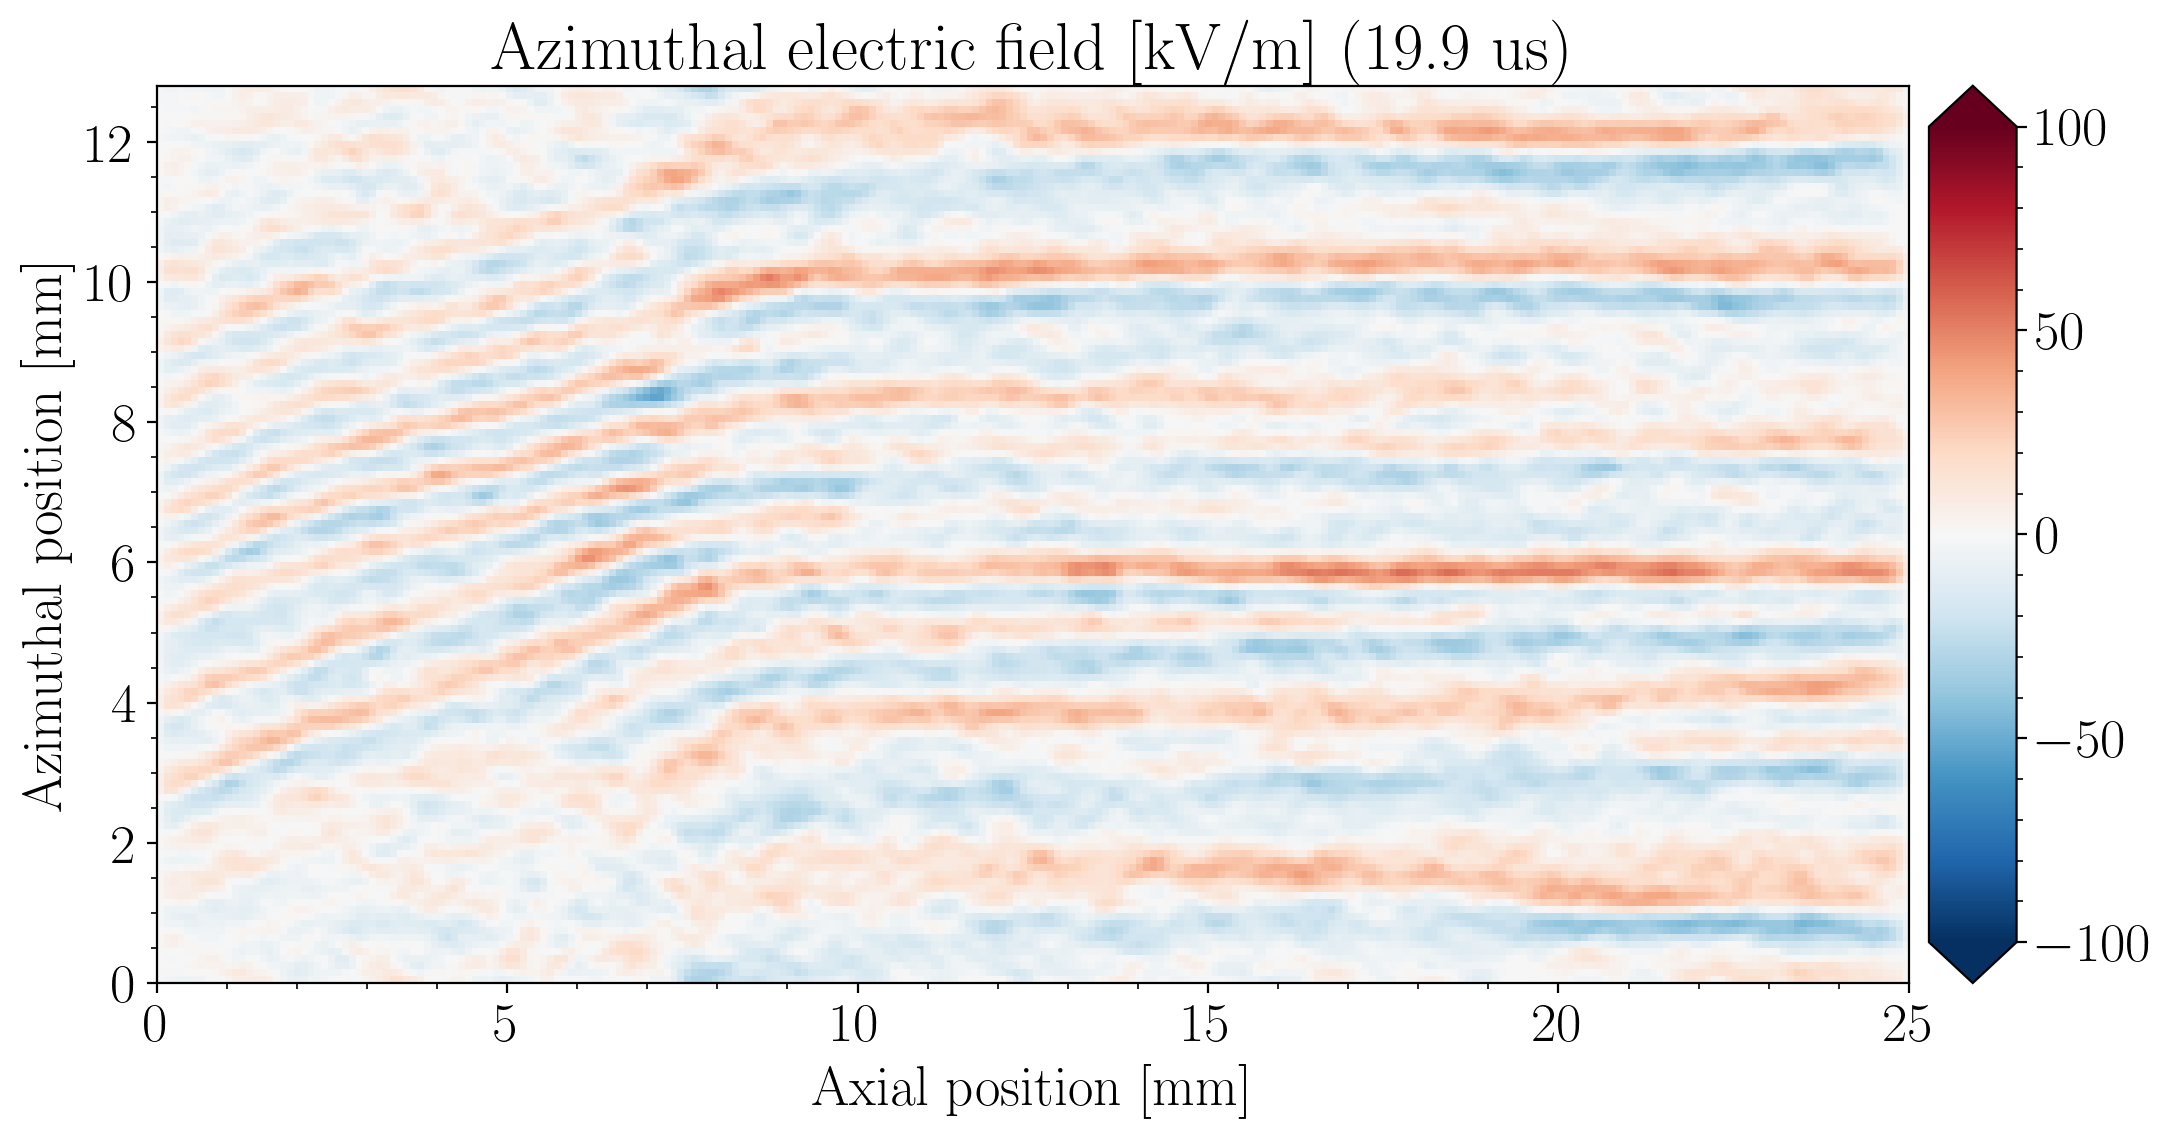

In [12]:
if True:
    animate_quantity_2D(archive_dir / "base_2x_2000K_1" / "processed", "Ez.mp4", "Ez", scale = 1/1000, vmin = -100, vmax = 100, frames = range(3800, 4000))
    animate_quantity_2D(archive_dir / "base_2x_noneutrals" / "processed", "Ez_static_2x.mp4", "Ez", scale = 1/1000, vmin = -100, vmax = 100, frames = range(200, 400))
    animate_quantity_2D(archive_dir / "benchmark_2x" / "processed", "Ez_benchmark.mp4", "Ez", scale = 1/1000, vmin = -100, vmax = 100, frames = range(200, 400))


# 1D animations

In [9]:
def animate_quantity_1D(data_dir, output_file, field = "Ez", scale = 1.0, frames=None, dim=0, fmin=None, fmax=None):
    # Read metadata
    metadata = read_metadata(data_dir, field)
    dt = metadata["dt"]
    extent = metadata["extent"] * 1000 # convert to mm
    files = metadata["files"]
    field_name = metadata["name"]

    fig, ax = plt.subplots(1,1, figsize=(12, 7))
    arr = np.load(files[0]) * scale
    arr = np.mean(arr, axis=dim)

    left, right = (extent[0], extent[1]) if dim==0 else (extent[2], extent[3])
    grid = np.linspace(left, right, len(arr))
    line = ax.plot(grid, arr)[0]

    cathode_ind = math.floor(24/25 * len(arr))
    hline = ax.axhline(np.mean(arr[:cathode_ind]))

    if fmin is None:
        fmin = np.min(arr)
    if fmax is None:
        fmax = np.max(arr)

    ax.set(xlim = (left, right), ylim = (fmin, fmax), ylabel = field_name, title = f"{field_name} (t = 0.0 us)")
    ax.set_xlabel(f"{'Axial' if dim == 0 else 'Azimuthal'} position [mm]")
    
    def update(frame):
        # for each frame, update the data stored on each artist.
        arr = np.load(files[frame]) * scale
        arr = np.mean(arr, axis=dim)
        clear_output(wait=True)
        print(f"{frame=}, {arr.shape=}")
        line.set_ydata(arr)
        hline.set_ydata([np.mean(arr[:cathode_ind])])
        ax.set_title(f"{field_name} ({frame*dt*1e6:.1f} us)")
        return line

    if frames is None:
        frames = range(len(array_files))
    
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=60, repeat=False)
    anim.save(output_file)

In [10]:
if False:
    animate_quantity_1D(archive_dir / "base_2x_2000K_1" / "processed", "ux_ion.mp4", "ux_ions", scale = 1 / 1000, frames = range(1500, 1600, 2), dim=0, fmin=-20, fmax = 20)

# Reduced diags (time-resolved)

In [58]:
def get_reduced_diags(sim_dir: Path, neutrals: bool = False, Lx = 2.5e-2, Lz = 1.28e-2):
    volume = Lx * Lz
    reduced_dir = sim_dir / "reduced"
    particle_number_file = reduced_dir / "ParticleNumber.txt"
    particle_energy_file = reduced_dir / "ParticleEnergy.txt"
    field_energy_file = reduced_dir / "FieldEnergy.txt"

    output_dict = {}

    if neutrals:
        weight_ind = 6
    else:
        weight_ind = 5

    count_ind_i = 3
    count_ind_e = 4
    count_ind_n = 5
    
    weight_ind_i = weight_ind+1
    weight_ind_e = weight_ind+2
    weight_ind_n = weight_ind+3

    if os.path.exists(particle_number_file):
        # Plot particle counts
        particle_counts = np.genfromtxt(particle_number_file, skip_header=1, delimiter=" ")

        if particle_counts.size > 0:
            output_dict["particle_time"] = particle_counts[:, 1] * 1e6  
            output_dict["count_ion"] = particle_counts[:, count_ind_i]
            output_dict["count_ele"] = particle_counts[:, count_ind_e]
            output_dict["weight_ion"] = particle_counts[:, weight_ind_i]
            output_dict["weight_ele"] = particle_counts[:, weight_ind_e]
            output_dict["dens_ion"] = output_dict["weight_ion"] / volume
            output_dict["dens_ele"] = output_dict["weight_ele"] / volume
            if neutrals:
                output_dict["count_neu"] = particle_counts[:, count_ind_n]
                output_dict["weight_neu"] = particle_counts[:, weight_ind_n]
                output_dict["dens_neu"] = output_dict["weight_neu"] / volume
  
    if os.path.exists(particle_energy_file) and os.path.exists(field_energy_file):
        # Plot particle, field, and total energy in system
        particle_energy = np.genfromtxt(particle_energy_file, skip_header=1, delimiter=" ")
        field_energy = np.genfromtxt(field_energy_file, skip_header=1, delimiter=" ")

        if particle_energy.size > 0:
            output_dict["energy_time"] = time = particle_energy[:, 1] * 1e6
            output_dict["field_energy_J"] = field_energy[:, 2]
            output_dict["ion_energy_J"] = particle_energy[:, 3]
            output_dict["electron_energy_J"] = particle_energy[:, 4]

    return output_dict

In [59]:
def rms_amplitude(signal):
    mean = np.mean(signal)
    amplitude = np.sqrt(np.mean((signal - mean)**2))
    return amplitude

i=1,peak_to_peak=2.432471664385691e+17,rms=4.395837628439279e+16,mean=2.0678657942177133e+17, %mean = 117.6%


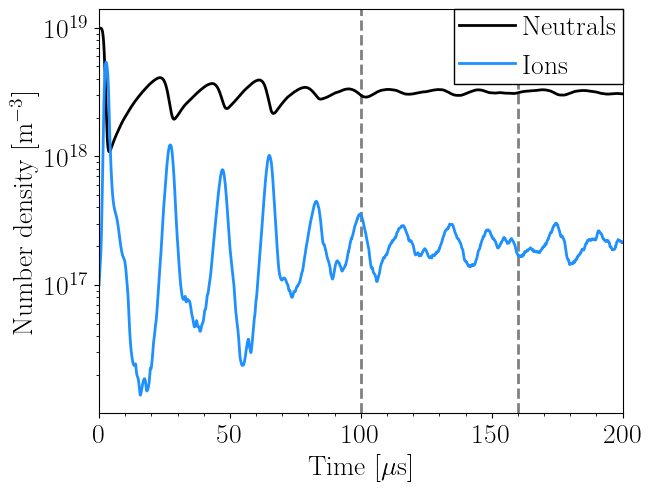

i=1,peak_to_peak=1.4827019957832157e+17,rms=3.0679575870420948e+16,mean=2.075453781281829e+17, %mean = 71.4%


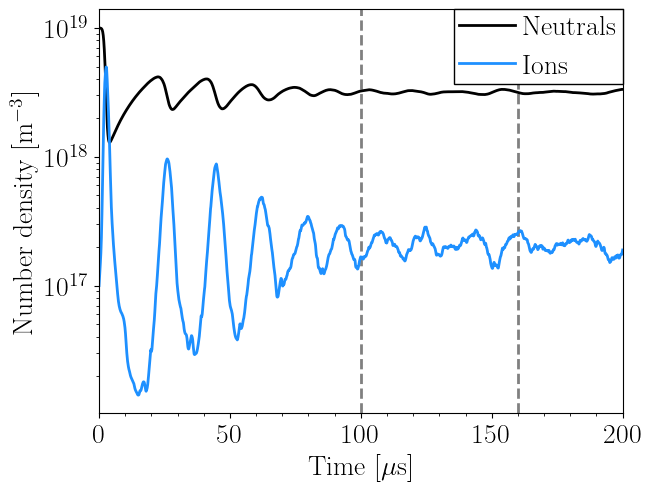

In [63]:
for case in ["2x", "4x"]:
    sim_dirs = [Path(f"../archive/base_{case}_2000K_{i}") for i in [1,2,3]]
    reduced = [get_reduced_diags(dir, neutrals=True) for dir in sim_dirs]
    
    fig, ax = plt.subplots(1,1, constrained_layout = True)

    start_time = 100
    
    for (i, diag) in enumerate(reduced):
        if i != 1:
            continue
        t_part = diag["particle_time"]
        inds = t_part >= start_time
        ni = diag["dens_ion"]
        nn = diag["dens_neu"]
        start_index = 100
        ax.plot(t_part, nn, color = 'black', label = "Neutrals" if i == 1 else "", alpha = 1.0 if i == 1 else 0.35)
        ax.plot(t_part, ni, color = 'dodgerblue', label = "Ions" if i == 1 else "", alpha = 1.0 if i == 1 else 0.35)
        peak_to_peak = np.max(ni[inds]) - np.min(ni[inds])
        rms = rms_amplitude(ni[inds])
        mean = np.mean(ni[inds])
        print(f"{i=},{peak_to_peak=},{rms=},mean={np.mean(ni[inds])}, %mean = {peak_to_peak/mean*100:.1f}%")
        ax.axvline(100, color = "gray", linestyle = "dashed", zorder=-1)
        ax.axvline(160, color = "gray", linestyle = "dashed", zorder=-1)
        
    ax.set_xlabel("Time [$\mu$s]")
    ax.set_ylabel("Number density [m$^{-3}$]")
    ax.set_yscale('log')
    ax.set_xlim(0, 200)
    ax.legend()
    save_and_close(fig, f"variance_{case}")

i=0,peak_to_peak=1.504673861756784e+17,rms=2.698926918019256e+16,mean=2.0288431382686746e+17, %mean = 74.2%
i=1,peak_to_peak=1.5479269588206884e+18,rms=4.0749500656181754e+17,mean=2.505197741135395e+17, %mean = 617.9%


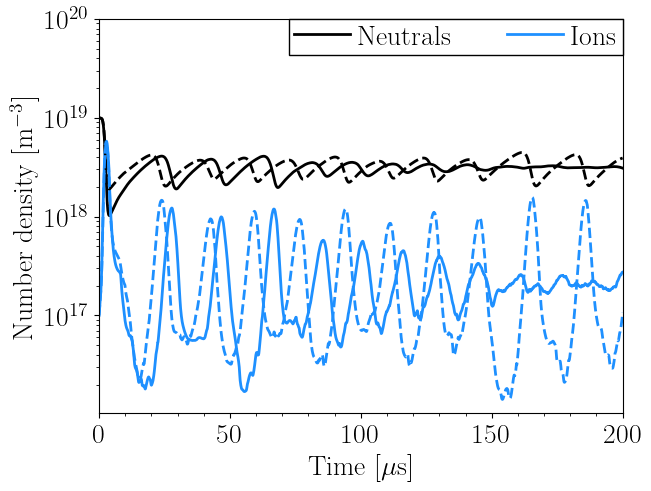

In [58]:
case = "2x"
sim_dirs = [Path(f"../archive/base_{case}_2000K_1"), Path(f"../archive/base_{case}_2000K_recombine")]
reduced = [get_reduced_diags(dir, neutrals=True) for dir in sim_dirs]

fig, ax = plt.subplots(1,1, constrained_layout=True)
styles = ["-", "--"]

start_time = 150

for (i, diag) in enumerate(reduced):
    t_part = diag["particle_time"]
    inds = t_part >= start_time
    ni = diag["dens_ion"]
    nn = diag["dens_neu"]
    ax.plot(t_part, nn, color = 'black', label = "Neutrals" if i == 0 else "", linestyle = styles[i])
    ax.plot(t_part, ni, color = 'dodgerblue', label = "Ions" if i == 0 else "", linestyle = styles[i])
    peak_to_peak = np.max(ni[inds]) - np.min(ni[inds])
    rms = rms_amplitude(ni[inds])
    mean = np.mean(ni[inds])
    print(f"{i=},{peak_to_peak=},{rms=},mean={np.mean(ni[inds])}, %mean = {peak_to_peak/mean*100:.1f}%")
    
    
ax.set_xlabel("Time [$\mu$s]")
ax.set_ylabel("Number density [m$^{-3}$]")
ax.set_yscale('log')
ax.set_xlim(0, 200)
ax.set_ylim(top = 1e20)
ax.legend(ncols=2, loc = 'upper right')
save_and_close(fig, f"recombination_{case}")

# Time-dependent properties

In [19]:
def extract_data_in_range(data_dir, tmin, tmax, fields):
    data_dir = Path(data_dir)
    metadata = read_metadata(data_dir, fields[0])
    dt = metadata["dt"]
    extent = metadata["extent"]
    shape = metadata["shape"]

    first_frame = math.floor(tmin / dt)
    last_frame = math.floor(tmax / dt)
    times = np.arange(first_frame, last_frame+1) * dt

    xgrid = np.linspace(extent[0], extent[1], shape[1])
    zgrid = np.linspace(extent[2], extent[3], shape[0])

    out = dict(t=times, x=xgrid, z=zgrid)

    for field in fields:
        out[field] = []
        field_metadata = read_metadata(data_dir, field)
        for i in range(first_frame, last_frame+1):
            out[field].append(np.load(field_metadata["files"][i]))

    return out

In [20]:
def lowpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

def normalize(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    return (signal - mean) / std

def filter_and_normalize(signal, cutoff, sample_rate, normalizer='filtered', method='zscore'):
    filtered = lowpass(signal, cutoff, sample_rate)
    
    norm = filtered if normalizer == 'filtered' else signal

    if method == 'zscore':
        offset = np.mean(norm)
        range = np.std(norm)
    elif method == 'minmax':
        offset = np.min(norm)
        range = np.max(norm) - offset
    elif method == 'meanrange':
        offset = np.mean(norm)
        range = (np.max(norm) - np.min(norm))/2
    else:
        raise ArgumentError("Invalid normalization method. Select one of 'zscore', 'minmax' and 'meanrange'")
     
    return (signal - offset) / range, (filtered - offset) / range 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [21]:
def compute_anomalous_force(data, avg_time):
    t = data["t"]
    Ez = np.array(data["Ez"])
    ni = np.array(data["ne"])
    dt = t[1] - t[0]
    avg_window_size = math.ceil(avg_time / dt)
    kernel = np.ones(avg_window_size) / avg_window_size
    Ez_avg = scipy.ndimage.convolve1d(Ez, kernel, axis=0)
    ni_avg = scipy.ndimage.convolve1d(ni, kernel, axis=0)
    force = lib.q_e * (ni - ni_avg) * (Ez - Ez_avg)
    force_avg = scipy.ndimage.convolve1d(force, kernel, axis=0)
    return force_avg

In [22]:
FIELD_NAMES = {
    "x": "Axial position",
    "t": "Time",
    "Ex": "Electric field",
    "Ez": "Azimuthal electric field",
    "ux_ions": "Ion velocity",
    "Te": "Electron temperature",
    "nn": "Neutral density",
    "ni": "Ion density",
    "ux_neutrals": "Neutral velocity",
    "anom_force": "Anom. force density",
}

FIELD_TEX = {
    "Ez": "$E_y$",
    "ni": "$n_i$",
}

FIELD_UNITS = {
    "x": "mm",
    "t": "$\mu$s",
    "Ex": "kV/m",
    "ux_ions": "km/s",
    "Te": "eV",
    "nn": "m$^{-3}$",
    "ni": "m$^{-3}$",
    "ux_neutrals": "m/s",
    "anom_force": "N/m$^3$",
}

def axis_label(field, tex=False):
    name = FIELD_TEX[field] if tex else FIELD_NAMES[field]
    return  f"{name} [{FIELD_UNITS[field]}]"

LETTERS = "abcdefghijklmnopqrstuvwxyz"

case = "2x"
phases = [106, 112, 116, 119] # for 2x base 2
#phases = [120, 122.7, 124, 125.6] # for 4x recombination

cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, len(phases)))

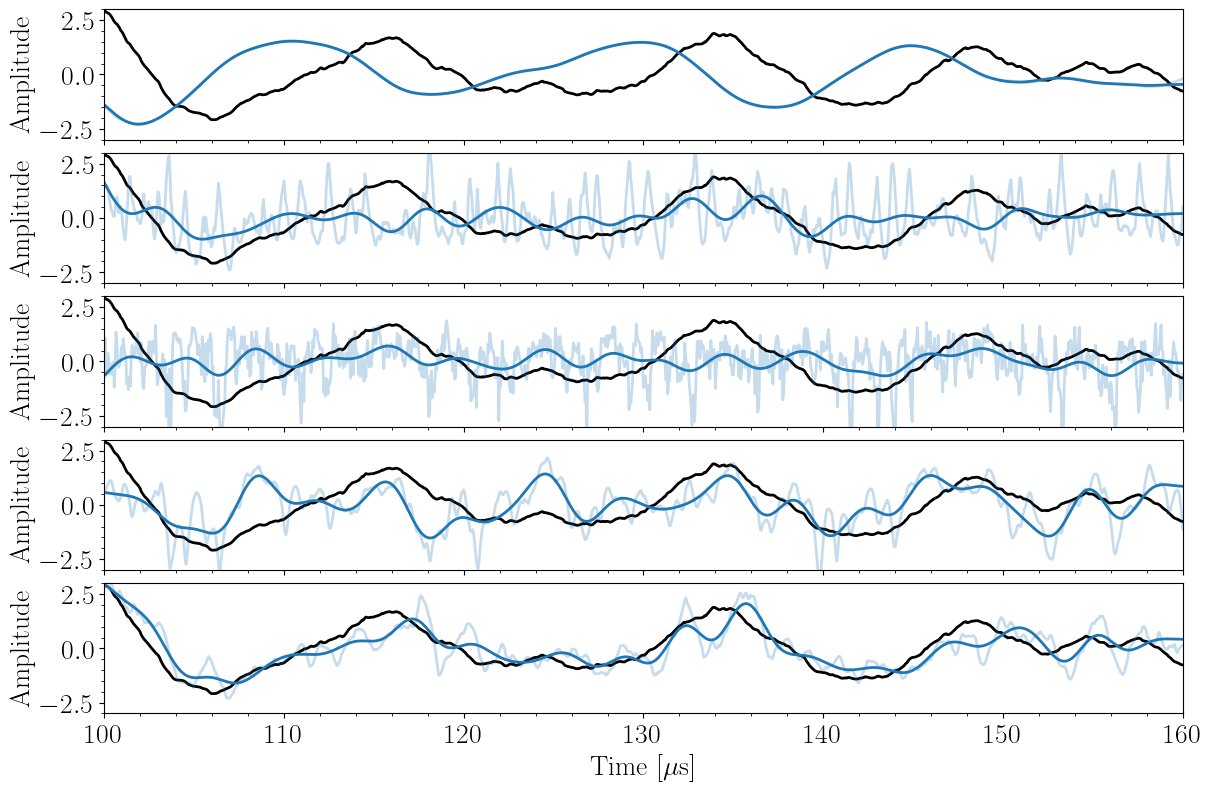

In [56]:
def plot_traces(case, phases):
    fields_to_extract = ["ni", "ne", "Ez"]
    fields_to_plot = ["nn", "Te", "Ex", "ux_ions", "anom_force"]
    #fields_to_plot = ["nn"]
    fields_to_extract += fields_to_plot
    fields_to_extract = set(fields_to_extract)
    fields_to_extract.discard("anom_force")
    fields_to_extract = list(fields_to_extract)

    data = extract_data_in_range(f"../archive/base_{case}_2000K_2/processed", 100e-6, 160e-6, fields_to_extract)
    anom_force = compute_anomalous_force(data, 1e-6)
    
    sample_rate = 1 / (data["t"][1] - data["t"][0])
    
    cutoff = 300_000
    t = data["t"] * 1e6
    indices = [find_nearest(t, phase) for phase in phases]

    func = np.mean
    
    norm_args = dict(
        normalizer = 'signal',
        method = 'zscore'
    )
    
    method_ylim = dict(
        meanrange = (-1, 1),
        minmax = (0,1),
        zscore = (-3, 3),
    )
    

    num_plots=  len(fields_to_plot)
    #num_plots=1
    fig, axes = plt.subplots(num_plots, 1, figsize = (12, 1.3 * (num_plots+1)), constrained_layout = True)
    if num_plots == 1:
        axes = [axes]
    color = 'tab:blue'
    alpha = 0.25
    #alpha = 1

    max_index=4
    _indices = indices[:max_index]
    _colors = colors[:max_index]

    max_ax_index=4
    
    for (ax_index, field) in enumerate(fields_to_plot):
        if ax_index > max_ax_index:
            break
        name = FIELD_NAMES[field]
        ax = axes[ax_index]
        cathode_ind = math.floor(lib.cathode_frac * len(data["x"]))
        ni_avg = [np.mean(x[:, :cathode_ind]) for x in data["ni"]]
        ni_raw, ni_filtered = filter_and_normalize(ni_avg, cutoff, sample_rate, **norm_args)
        
        ax.plot(t, ni_raw, color = 'black')
        #ax.plot(t, ni_filtered, color = 'black', label = "Ion density")

        if field == "anom_force":
            field_data = [func(x[:, :cathode_ind]) for (i, x) in enumerate(anom_force)]
        else:
            field_data = [func(x[:, :cathode_ind]) for x in data[field]]
        
        raw, filtered = filter_and_normalize(field_data, cutoff, sample_rate, **norm_args)
        ax.plot(t, raw, color=color, alpha=alpha)
        ax.plot(t, filtered, label=name, color=color)
    
        xlabel = "" if ax_index < num_plots-1 else axis_label("t")
        ax.set(ylabel = "Amplitude", xlabel = xlabel, xlim=(t[0], t[-1]), ylim=method_ylim[norm_args['method']])
        if ax_index < num_plots-1:
            ax.set_xticklabels([])

        # Plot specific time moments
        markersize=12
        s = markersize**2
        offset = 8
        offsets = [(-1, -2.5), (-1, 1.5), (1,1), (1,1)]
        #ax.scatter(t[_indices], ni_filtered[_indices], s, zorder=20, color = _colors)

        #if ax_index == 0: 
        #    for (i, idx) in enumerate(_indices):
        #        point = (t[idx], ni_filtered[idx])
        #        off_x, off_y = offsets[i]
        #        ax.annotate(f"$t_{i}$", point, xytext = (off_x*offset, off_y*offset), textcoords='offset points')
    
        #ax.annotate(f"({LETTERS[ax_index]})", (0.98,0.95), xycoords = 'axes fraction', ha = 'right', va = 'top', fontsize=25)
        #ax.legend(ncols=4, labelspacing=0.4, columnspacing=0.5, handlelength=1, loc = 'lower right')
        ax_index += 1
        
    save_and_close(fig, f"signal_{case}_f{max_ax_index}")

plot_traces(case, phases)

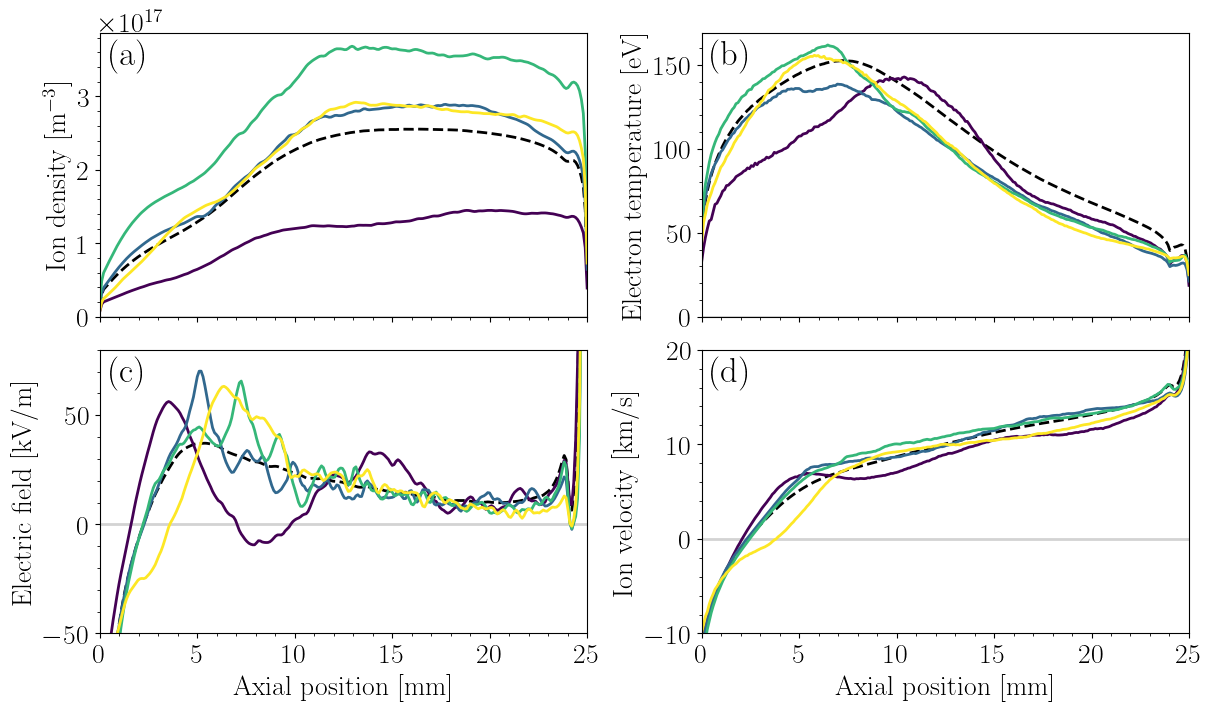

In [27]:
def plot_axial_phases(case, phases):
    data = extract_data_in_range(f"../archive/base_{case}_2000K_2/processed", 105e-6, 125e-6, ["Ex", "Ez", "ux_ions", "nn", "ni", "ne", "Te"])
    sample_rate = 1 / (data["t"][1] - data["t"][0])
    t = data["t"] * 1e6
    indices = [find_nearest(t, phase) for phase in phases]
    
    fields_to_plot = ["ni", "Te", "Ex", "ux_ions"]

    h = 2
    w = math.ceil(len(fields_to_plot)/2)
    fig, axes = plt.subplots(h, w, figsize = (12,7), constrained_layout=True)
    axes = axes.flatten()
    
    for (ax_index, field) in enumerate(fields_to_plot):
        scale = 1
        ylim = (0, None)
        ax = axes[ax_index]
    
        if field not in ["Ex", "ux_ions", "Te", "ni", "nn", "anom_force"]:
            continue
        
        if field == "Ex":
            ylim = (-50, 80)
            scale = 1/1000
        elif field == "ux_ions":
            ylim = (-10, 20)
            scale = 1/1000
        elif field == "anom_force":
            ylim = (-100, 100)

        if field == "anom_force":
            field_data = compute_anomalous_force(data, 1e-6)
            f_avg = np.mean(field_data, axis=0)
        else:
            field_data = data[field]
            f_avg = np.mean(field_data, axis=0)

        x = data["x"] * 1000
        
        avg_window = 0.2e-6
        inds = math.floor(avg_window * sample_rate)
        
        if len(f_avg.shape) == 2:
            f_avg = np.mean(f_avg, axis=0)
        ax.plot(x, f_avg * scale, color = 'black', linestyle = "--")
        
        for (i, idx) in enumerate(indices):
            # Average over 2 times averaging block
            f = np.mean([field_data[idx-inds + i] for i in range(0, 2*inds)], axis=0)
            if len(f.shape) == 2:
                f = np.mean(f, axis=0)
            ax.plot(x, f * scale, color=colors[i], label=f"$t_{{{i}}}$")
    
        xlabel = axis_label("x")
        if ax_index // h == 0:
            ax.set_xticklabels([])
            xlabel = ""
        
        ax.annotate(f"({LETTERS[ax_index]})", (0.02, 0.98), xycoords = 'axes fraction', va = 'top', fontsize = 25)
        ax.set(xlabel = xlabel, xlim = (x[0], x[-1]), ylabel = axis_label(field), ylim = ylim)
        ax.axhline(0, color = 'lightgray', zorder=-1)
        ax.legend(ncols=4, labelspacing=0.4, columnspacing=0.5, handlelength=1)

    save_and_close(fig, f"phases_{case}_p4")

plot_axial_phases(case, phases)

In [18]:
def plot_fields_2D(case = "2x", xs = (1.0e-2,)):
    data = extract_data_in_range(f"../archive/base_{case}_2000K_2/processed", 105e-6, 125e-6, ["ni", "Ez"])
    sample_rate = 1 / (data["t"][1] - data["t"][0])
    t = data["t"] * 1e6
    indices = [find_nearest(t, phase) for phase in phases]
    annotate_args = dict(xy = (0.98, 0.98), xycoords='axes fraction', fontsize=25, va = 'top', ha = 'right')

    N = len(phases)
    fig, axes = plt.subplots(N, 2, constrained_layout=True, figsize = (12, 13.5))

    x = data["x"] * 1000
    y = data["z"] * 1000
    extent = (x[0], x[-1], y[0], y[-1])
    Ez = [data["Ez"][idx]/1000 for idx in indices]
    ni = [data["ni"][idx] for idx in indices]

    max_abs_E = 0.75 * np.max(np.abs(Ez))
    norm_E = mpl.colors.Normalize(vmin = -max_abs_E, vmax=max_abs_E)
    norm_n = mpl.colors.Normalize(vmin = 0.0, vmax = 0.75* np.max(ni))

    im_args = dict(extent=extent, origin='lower')
    ims = []
    
    for (irow, row) in enumerate(axes):
        im_0 = row[0].imshow(Ez[irow], norm=norm_E, cmap = "RdBu_r", **im_args)
        im_1 = row[1].imshow(ni[irow], norm=norm_n, **im_args)
        if irow == 1:
            ims = [im_0, im_1]

        row[1].set_yticklabels([])
        row[0].set_ylabel("Azimuthal pos. [mm]")

        for (j, ax) in enumerate(row):
            if irow < N-1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(axis_label("x"))

            color = 'black' if j == 0 else 'white'
            for x in xs:
                ax.axvline(x * 1000, color = color, linestyle = 'dashed', alpha = 0.5)

            ax.annotate(f"({LETTERS[2*irow + j]}) $t = {phases[irow]:d}$ $\mu$s", color = color, **annotate_args) 

    cbar_args = dict(orientation='horizontal', location = 'top')
    cb_E = fig.colorbar(ims[0], ax = axes[0,0], label = "Azimuthal electric field [kV/m]", extend='both', **cbar_args)
    cb_n = fig.colorbar(ims[1], ax = axes[0,1], label = "Ion density [m$^{-3}$]", extend='max', **cbar_args)
    for cb in [cb_E, cb_n]:
        cb.ax.xaxis.set_tick_params(pad=-2)
        cb.ax.xaxis.labelpad=10
    
    save_and_close(fig, f"timedep_2d_{case}")

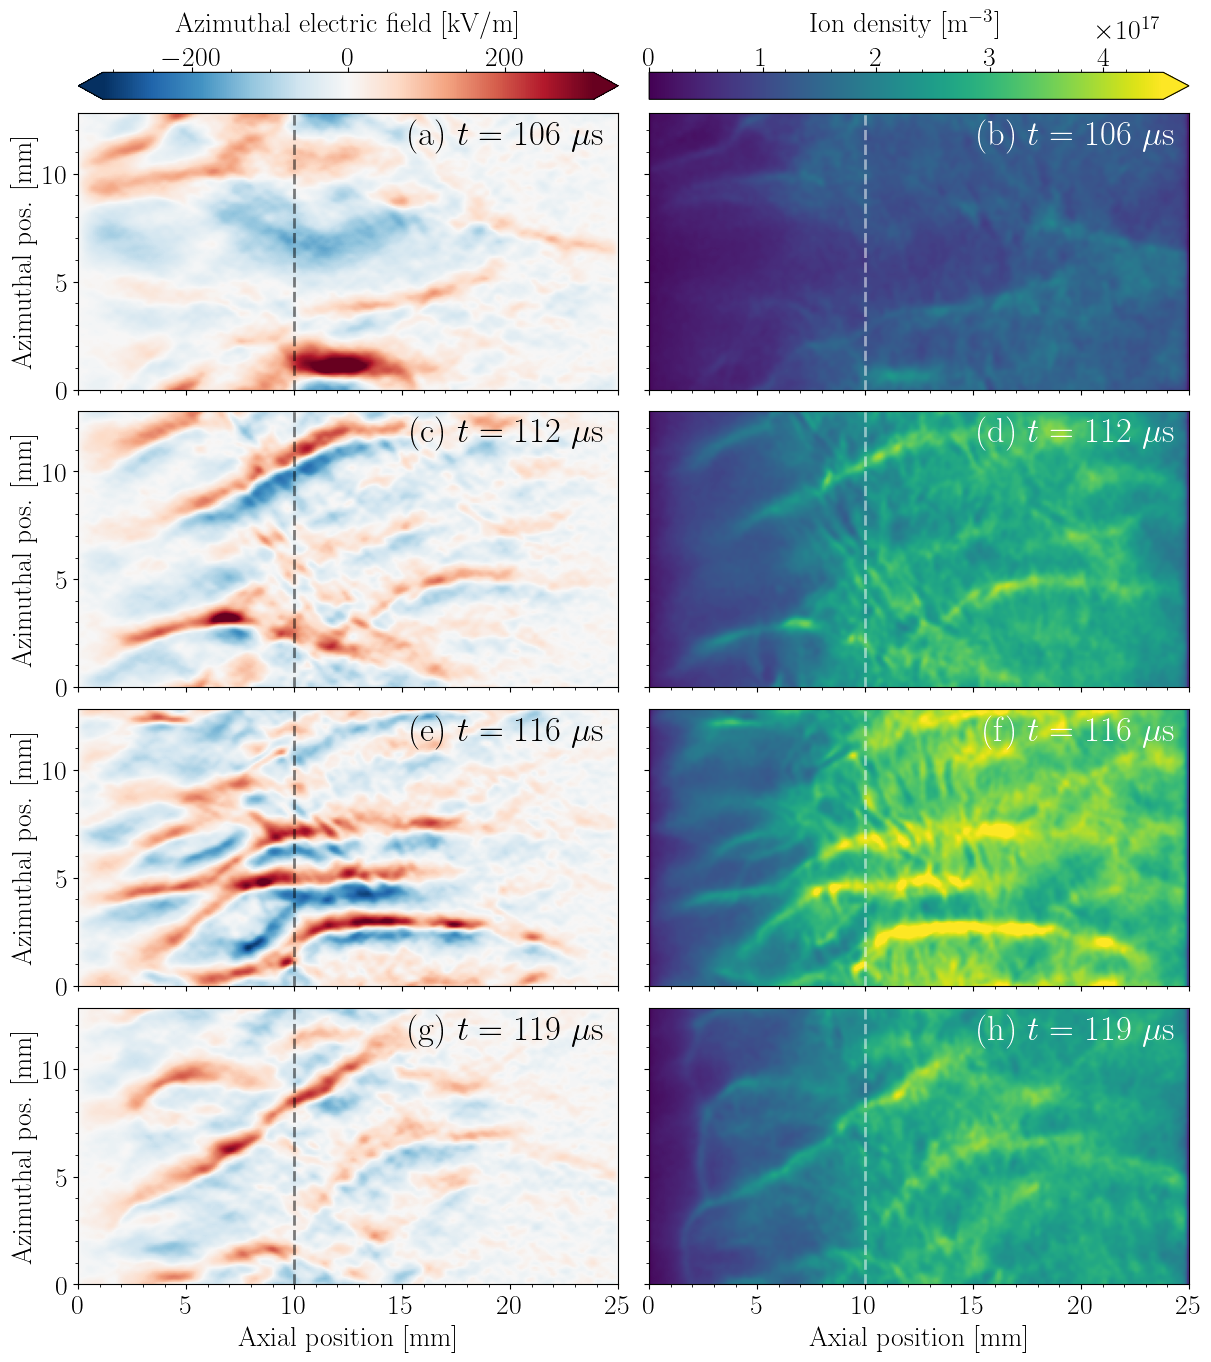

In [37]:
plot_fields_2D(xs = [1e-2])

# Time-averaged properties

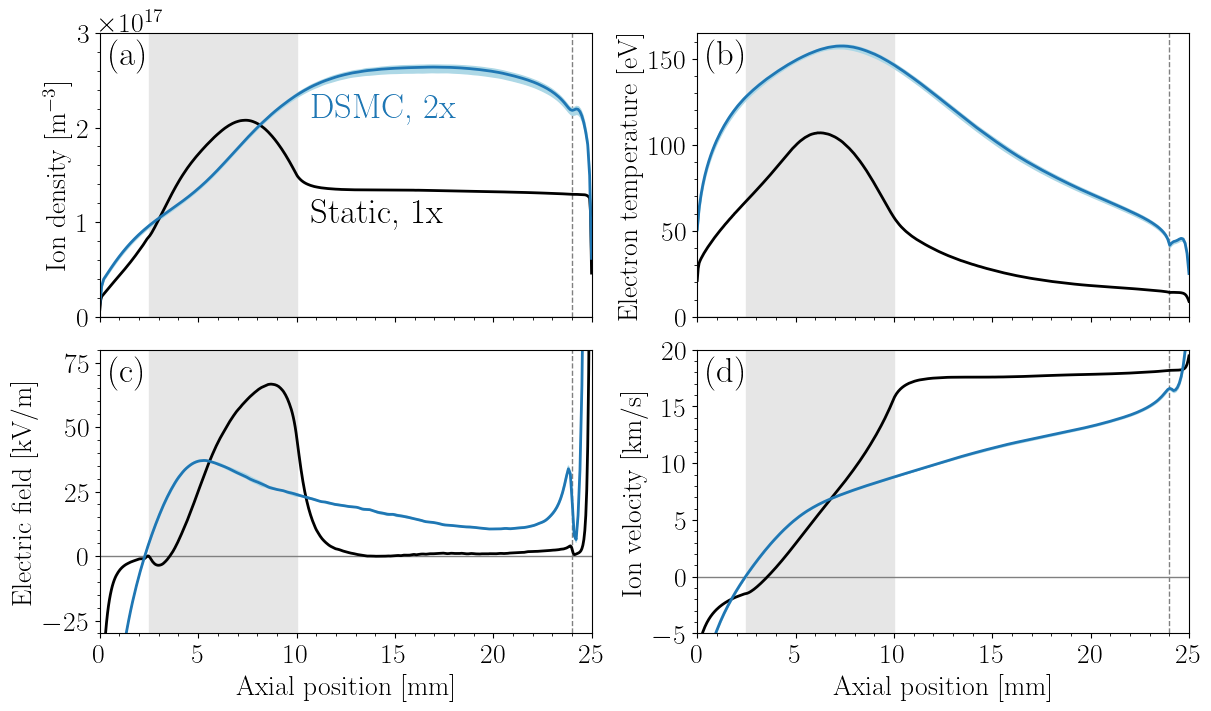

8.697255755292323e+18 5.958334554594074e+17
526.045152704536 840.1770764667668


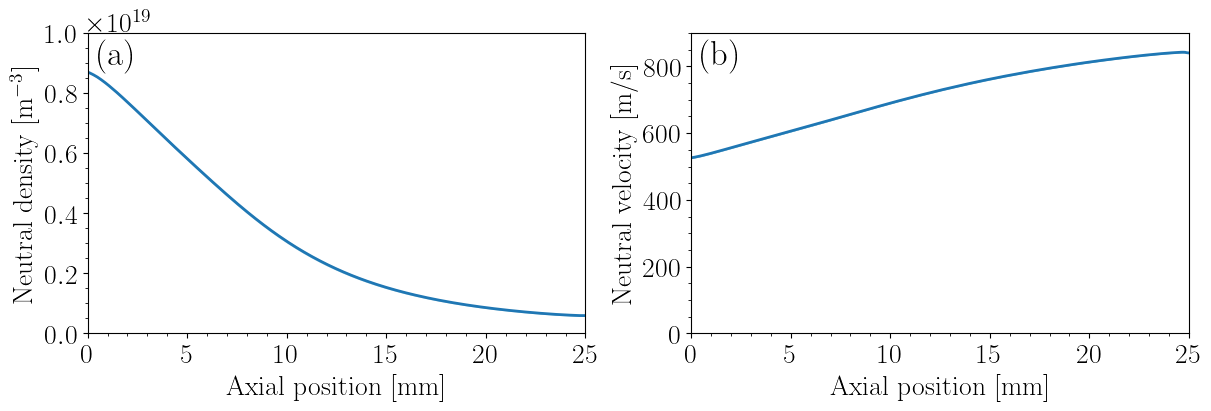

In [38]:
def plot_time_averaged(case):
    ARCHIVE_DIR = Path("../archive")
    baseline_sim_dir = ARCHIVE_DIR / f"base_1x_noneutrals" / "processed"
    sims_with_ionization = [ARCHIVE_DIR / f"base_{case}_2000K_{i}" / "processed" for i in range(1,4)]
    iz_avg_start_time = 150e-6
    baseline_avg_start_time = 12e-6
    
    fields = ["Ex", "ux_ions", "ux_neutrals", "nn", "ni", "Te"]
    baseline_data = extract_data_in_range(baseline_sim_dir, baseline_avg_start_time, 20e-6, fields)
    data_with_ionization = [extract_data_in_range(dir, iz_avg_start_time, 200e-6, fields) for dir in sims_with_ionization]
    
    fig, axes = plt.subplots(2,2, figsize = (12,7), constrained_layout=True)
    axes = axes.flatten()
    annotate_args = dict(xycoords='axes fraction', fontsize=25)

    # Plasma
    fields_to_plot = ["ni", "Te", "Ex", "ux_ions"]
    
    for (ax_index, field_to_plot) in enumerate(fields_to_plot):
        ax = axes[ax_index]
        scale = 1
        
        if field_to_plot == "Ex":
            ylim = (-30, 80)
            scale = 1/1000
        elif field_to_plot == "ux_ions":
            ylim = (-5, 20)
            scale = 1/1000
        elif field_to_plot == "ni":
            ylim = (0, 3e17)
        elif field_to_plot == "Te":
            ylim = (0, 165)
        
        x_scale = 1000
        baseline_x = baseline_data["x"] * x_scale
        baseline_field = np.mean(baseline_data[field_to_plot], axis=(0,1)) * scale
        
        ax.plot(baseline_x, baseline_field, color = 'black')
        
        sim_x = data_with_ionization[0]["x"] * x_scale
        sim_fields = np.array([np.mean(_data[field_to_plot], axis=(0,1)) * scale for _data in data_with_ionization])
        mean_sim = np.mean(sim_fields, axis=0)
        min_sim = np.min(sim_fields, axis=0)
        max_sim = np.max(sim_fields, axis=0)
        
        ax.fill_between(sim_x, min_sim, max_sim, color = 'lightblue')
        ax.plot(sim_x, mean_sim, linewidth=2)
    
        xlabel = axis_label("x") if i == 1 else ""
        if ax_index // 2 == 0:
            ax.set_xticklabels([])
            xlabel = ""
        ax.set(xlabel = xlabel, xlim = (baseline_x[0], baseline_x[-1]), ylabel = axis_label(field_to_plot), ylim=ylim)
        ax.annotate(f"({LETTERS[ax_index]})", (0.02, 0.98), va = 'top', **annotate_args)
    
        if ax_index == 0:
            ax.annotate(f"DSMC, 2x", (0.43, 0.7), color = 'tab:blue', **annotate_args)
            ax.annotate(f"Static, 1x", (0.43, 0.33), **annotate_args)
        
        ax.axhline(0, color = 'gray', zorder=-1, linewidth=1)
        ax.axvline(X_CATHODE_MM, color = 'gray', linestyle = 'dashed', zorder=-1, linewidth=1)
        ax.axvspan(X_IZ_MIN_MM, X_IZ_MAX_MM, color = [0.9] * 3, zorder = -2)
    
    save_and_close(fig, f"avg_{case}")

    # Neutrals
    fig, axes = plt.subplots(1,2, layout = 'constrained', figsize = (12,4))
    fields_to_plot = ["nn", "ux_neutrals"]
    for (field_ind, ax) in enumerate(axes):
        field_to_plot = fields_to_plot[field_ind]
        scale = 1
    
        if field_to_plot == "ux_neutrals":
            ylim = (0, 900)
        elif field_to_plot == "nn":
            ylim = (0, 1e19)
        
        x_scale = 1000
        baseline_x = baseline_data["x"] * x_scale
        baseline_field = np.mean(baseline_data[field_to_plot], axis=(0,1)) * scale

        sim_x = data_with_ionization[0]["x"] * x_scale
        sim_fields = np.array([np.mean(_data[field_to_plot], axis=(0,1)) * scale for _data in data_with_ionization])
        mean_sim = np.mean(sim_fields, axis=0)
        min_sim = np.min(sim_fields, axis=0)
        max_sim = np.max(sim_fields, axis=0)
        print(mean_sim[0], mean_sim[-1])
        
        ax.fill_between(sim_x, min_sim, max_sim, color = 'lightblue')
        ax.plot(sim_x, mean_sim, linewidth=2)
        ax.set(xlabel = axis_label("x"), xlim = (baseline_x[0], baseline_x[-1]), ylabel = axis_label(field_to_plot), ylim=ylim)
        ax.annotate(f"({LETTERS[field_ind]})", (0.02, 0.98), va = 'top', **annotate_args)
    
    save_and_close(fig, f"avg_neutrals_{case}")

plot_time_averaged("2x")

Average steady state ion particles per cell: 156.2398478291728
Average steady state neutral particles per cell: 261.15594887900187


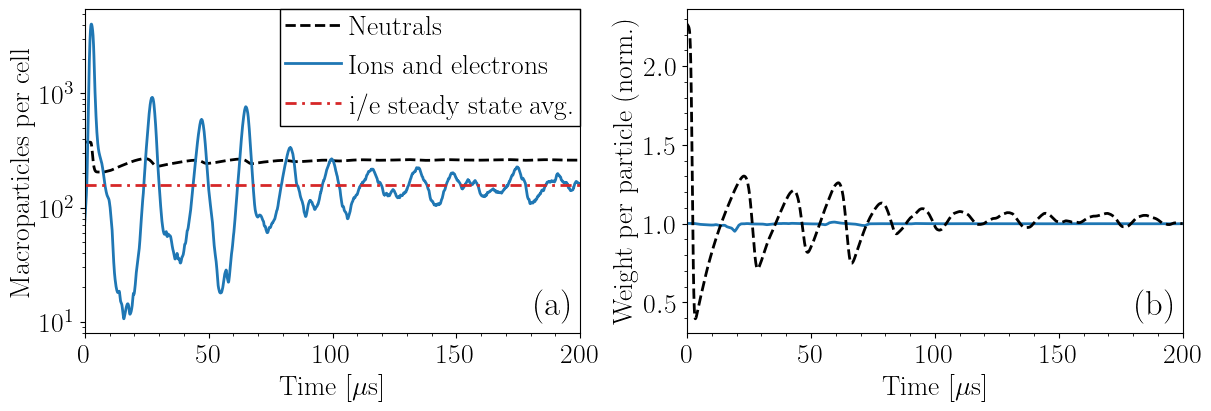

In [39]:
def plot_particle_weights(case=2):
    Nx_base = 512
    Ny_base = 256
    Nx = Nx_base // case
    Ny = Ny_base // case
    num_cells = Nx * Ny
    
    sim_dir = Path(f"../archive/base_{case}x_2000K_2")
    diags = get_reduced_diags(sim_dir, neutrals=True)
    
    fig, axes = plt.subplots(1,2, constrained_layout=True, figsize=(12,4))
    
    t = diags["particle_time"]
    weight_i = diags["weight_ion"]
    weight_e = diags["weight_ele"]
    weight_n = diags["weight_neu"]
    count_i = diags["count_ion"]
    count_e = diags["count_ele"]
    count_n = diags["count_neu"]
    
    
    avg_start_us = 150
    dt = t[1] - t[0]
    ax_opts = dict(xlabel = 'Time [$\mu$s]', xlim = (0,200))
    annotate_opts = dict(xy=(0.99, 0.03), xycoords="axes fraction", ha='right', va='bottom', fontsize=25)
    start_ind = math.floor(avg_start_us / dt)
    
    ppc_ax = axes[0]
    
    # Particles per cell
    ppc_i = count_i / num_cells
    ppc_e = count_e / num_cells
    ppc_n = count_n / num_cells
    
    avg_ppc_i = np.mean(ppc_i[start_ind:])
    avg_ppc_n = np.mean(ppc_n[start_ind:])
    print(f"Average steady state ion particles per cell: {avg_ppc_i}")
    print(f"Average steady state neutral particles per cell: {avg_ppc_n}")
    
    ppc_ax.plot(t, ppc_n, label = "Neutrals", color = 'black', linestyle='dashed')
    ppc_ax.plot(t, ppc_i, color = 'tab:blue', label = "Ions and electrons", linewidth=2)
    ppc_ax.axhline(avg_ppc_i, color = 'tab:red', dashes = [4, 2, 1, 2], label = 'i/e steady state avg.')
    ppc_ax.legend()
    ppc_ax.annotate('(a)', **annotate_opts)
    ppc_ax.set(yscale = 'log', ylabel = 'Macroparticles per cell', **ax_opts)
    
    # Weight per particle
    wpp_ax = axes[1]
    wpp_i = weight_i / count_i
    wpp_n = weight_n / count_n
    rel_wpp_i = wpp_i / wpp_i[-1]
    rel_wpp_n = wpp_n / wpp_n[-1]
    wpp_ax.plot(t, rel_wpp_i, color = 'tab:blue')
    wpp_ax.plot(t, rel_wpp_n, color = 'black', linestyle = 'dashed')
    wpp_ax.annotate('(b)', **annotate_opts)
    wpp_ax.set(ylabel = "Weight per particle (norm.)", **ax_opts)
    
    plt.show()
    save_and_close(fig, "weight_evolution")
plot_particle_weights(case=2)

## Weight distributions

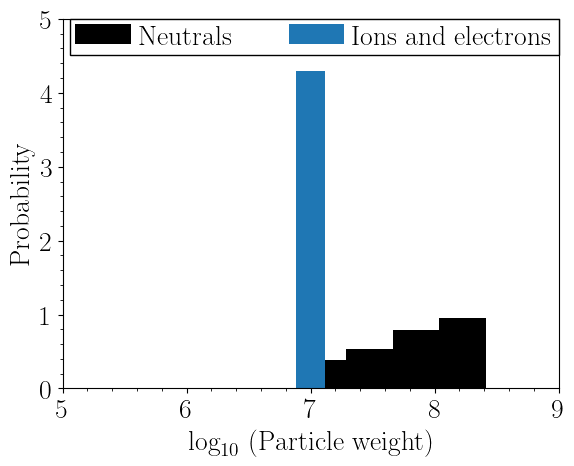

In [40]:
def plot_weight_distributions(case=2, index=0):
    sim_dir = Path(f"../archive/base_{case}x_2000K_2/particles")
    dirs = os.listdir(sim_dir)
    numbers = [int(x.split('_')[1]) for x in dirs]
    sorted_dirs = [x[0] for x in sorted(zip(dirs, numbers), key = lambda x: x[1])]

    ds = yt.load(Path(f"../archive/base_{case}x_2000K_2/particles") / sorted_dirs[index]).all_data()
    
    wt_neu = ds[("neutrals", "particle_weight")].ndarray_view()
    wt_ion = ds[("ions", "particle_weight")].ndarray_view()
    
    fig, ax = plt.subplots(1,1)
    ax.hist(np.log10(wt_neu), bins=25, color = 'black', density=True, label = "Neutrals")
    ax.hist(np.log10(wt_ion), bins=25, color = 'tab:blue', density=True, label = "Ions and electrons")
    ax.set(xlabel = "$\log_{10}$ (Particle weight)", ylabel = "Probability", xlim=(5,9), ylim=(0,5))
    ax.legend(ncols=2)

    save_and_close(fig, "weight_histogram")

plot_weight_distributions(case=2, index=100)

# Anomalous friction force

We compute the anomalous friction force as

$$
R_{ei}^j = q_e \langle \delta n_e \delta E_j \rangle = q_e \langle \left[\langle n_e \rangle_t - n_e(t)\right] \left[\langle E_j \rangle_t - E_j(t)\right]\rangle_t,
$$

where $\langle \cdot \rangle_t$ denotes averaging over a specified time period, here 1 microsecond.


In [41]:
def extract_static_anom_force(case, avg_time):
    datasets = [extract_data_in_range(f"../archive/base_{case}x_2000K_{num}/processed", 150e-6, 200e-6, ["Ez", "ne"]) for num in [1,2,3]]
    forces = np.array([np.mean(compute_anomalous_force(d, avg_time), axis=(0,1)) for d in datasets])
    min_force = np.min(forces, axis=0)
    max_force = np.max(forces, axis=0)
    mid_force = np.mean(forces, axis=0)
    return datasets[0]["x"] * 1000, min_force, max_force, mid_force

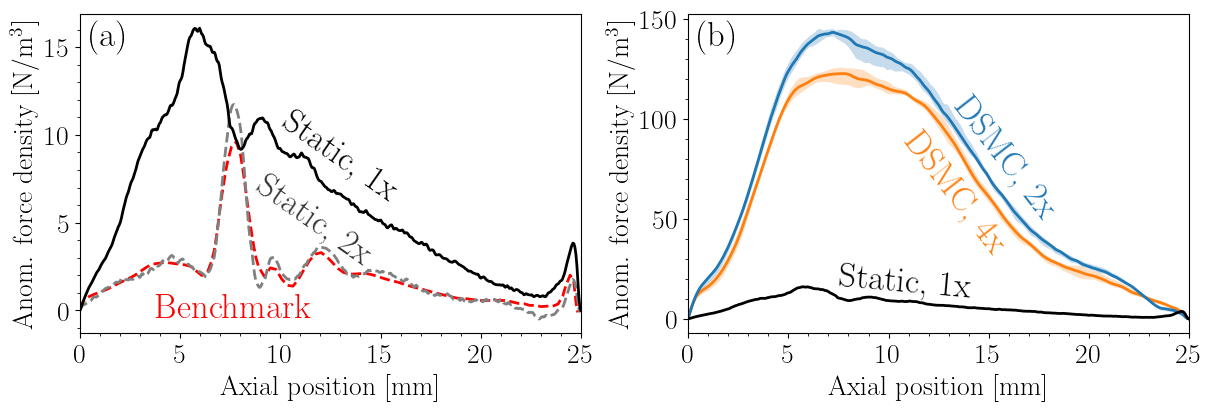

In [46]:
def plot_static_anom_force():
    x_2x, min_force_2x, max_force_2x, mid_force_2x = extract_static_anom_force(2, 1e-6)
    x_4x, min_force_4x, max_force_4x, mid_force_4x = extract_static_anom_force(4, 1e-6)

    # force from Petronio et al. Phys. Plasmas 32, 073513 (2025)
    benchmark_transport_petronio = np.genfromtxt("benchmark_transport_petronio.txt", delimiter=",")
    petronio_x = benchmark_transport_petronio[:, 0]
    petronio_y = benchmark_transport_petronio[:, 1]

    data_1x_noiz = extract_data_in_range(f"../archive/base_1x_noneutrals/processed", 10e-6, 20e-6, ["Ez", "ne"])
    data_2x_noiz = extract_data_in_range(f"../archive/base_2x_noneutrals/processed", 12e-6, 20e-6, ["Ez", "ne"])
    #data_2x_noiz = extract_data_in_range(f"../archive/benchmark_1x/processed", 12e-6, 20e-6, ["Ez", "ne"])
    force_1x_noiz = np.mean(compute_anomalous_force(data_1x_noiz, 1e-6), axis=(0,1))
    force_2x_noiz = np.mean(compute_anomalous_force(data_2x_noiz, 1e-6), axis=(0,1))
    
    fig, ax = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)
    annotate_args = dict(xycoords = "axes fraction", fontsize = 25, rotation_mode='anchor')
    label_args = dict(xy=(0.02, 0.98), va='top', **annotate_args)
    ax_args = dict(xlim = (0, 25), xlabel = axis_label("x"), ylabel = axis_label("anom_force"))
    
    # Baseline: no iz compared to LANDMARK benchmark across 1x, 2x
    # Benchmark forces
    ax_noiz = ax[0]
    ax_noiz.plot(petronio_x, petronio_y, color = 'red', linestyle = 'dashed')
    ax_noiz.plot(data_2x_noiz["x"] * 1000, force_2x_noiz, color = 'gray', linestyle = 'dashed')
    ax_noiz.plot(data_1x_noiz["x"] * 1000, force_1x_noiz, color = 'black')

    # Annotations
    ax_noiz.annotate("Benchmark", (0.15, 0.05), color = "red", **annotate_args)
    ax_noiz.annotate("Static, 1x", (0.4, 0.65), color = "black", rotation=-35, **annotate_args)
    ax_noiz.annotate("Static, 2x", (0.35, 0.45), color = (0.2, 0.2, 0.2), rotation=-35, **annotate_args)
    ax_noiz.annotate("(a)", **label_args)
    ax_noiz.set(**ax_args)
    
    # Simulations with ionization compared to 1x with no iz
    # 4x force
    ax_iz = ax[1]
    ax_iz.fill_between(x_4x, min_force_4x, max_force_4x, color = 'tab:orange', alpha = 0.25, linewidth=0)
    ax_iz.plot(x_4x, mid_force_4x, color = 'tab:orange')
    
    # 2x force
    ax_iz.fill_between(x_2x, min_force_2x, max_force_2x, color = 'tab:blue', alpha = 0.25, linewidth=0)
    ax_iz.plot(x_2x, mid_force_2x, color = 'tab:blue')
    
    # 1x without iz
    ax_iz.plot(data_1x_noiz["x"] * 1000, force_1x_noiz, color = 'black')

    # Annotations
    ax_iz.annotate("DSMC, 2x", (0.53, 0.71), color = "tab:blue", rotation = -52, **annotate_args)
    ax_iz.annotate("DSMC, 4x", (0.43, 0.6), color = "tab:orange", rotation = -52, **annotate_args)
    ax_iz.annotate("Static, 1x", (0.3, 0.15), color = "black", rotation=-5, **annotate_args)
    ax_iz.annotate("(b)", **label_args)
    ax_iz.set(**ax_args)

    save_and_close(fig, "anom_static")
    
plot_static_anom_force()

# Spectra

In [138]:
def plot_k_spectrum(fields, x = 1e-2):
    data_2x = extract_data_in_range(Path("../archive/base_2x_2000K_2/processed"), 150e-6, 200e-6, fields)
    data_noiz = extract_data_in_range(Path("../archive/base_1x_noneutrals/processed"), 15e-6, 20e-6, fields)
    data_noiz_2 = extract_data_in_range(Path("../archive/base_2x_noneutrals/processed"), 15e-6, 20e-6, fields)
   
    cases = [data_noiz, data_noiz_2, data_2x]
    colors = ["black", "gray", "tab:blue"]
    styles = ['solid', 'dashed', 'solid']
    names = ['Static, 1x', 'Static, 2x', 'DSMC, 2x']
    N = len(fields)

    fig, axes = plt.subplots(1,N, constrained_layout=True, figsize=(6*N,4))

    for (i, field) in enumerate(fields):
        ylim = (None, None)
        if field == "Ez":
            ylim = (1e4, 4e6)
            ylabel = "Amplitude [V/m]"
        elif field == "ni":
            ylim = (1e16, 2e18)
            ylabel = "Amplitude [m$^{-3}$]"
            
        for (j, case) in enumerate(cases):
            spectrum = lib.wavenumber_spectrum(case, field)
            ax = axes[i]
            x_index = find_nearest(spectrum["x_m"], x)
            lambda_mm = 1 / spectrum["frequency"] * 1000
            amplitude = spectrum["amplitudes"][x_index]
            ind_max = np.argmax(amplitude)
            ax.plot(lambda_mm, amplitude, color = colors[j], linestyle = styles[j], label = names[j])
            if j == 0:
                ax.set(xscale = 'log', yscale = 'log', xlim = (1e-1, 1.2e1), ylim = ylim, xlabel = "Azimuthal wavelength [mm]", ylabel = ylabel)
                ax.annotate(f"({LETTERS[i]}) {FIELD_TEX[field]}", (0.02, 0.98), va='top', xycoords = 'axes fraction', fontsize=25)
            if i == 1:
                ax.legend(labelspacing=0.25)

    save_and_close(fig, f"k_spectrum")

## Wavenumber

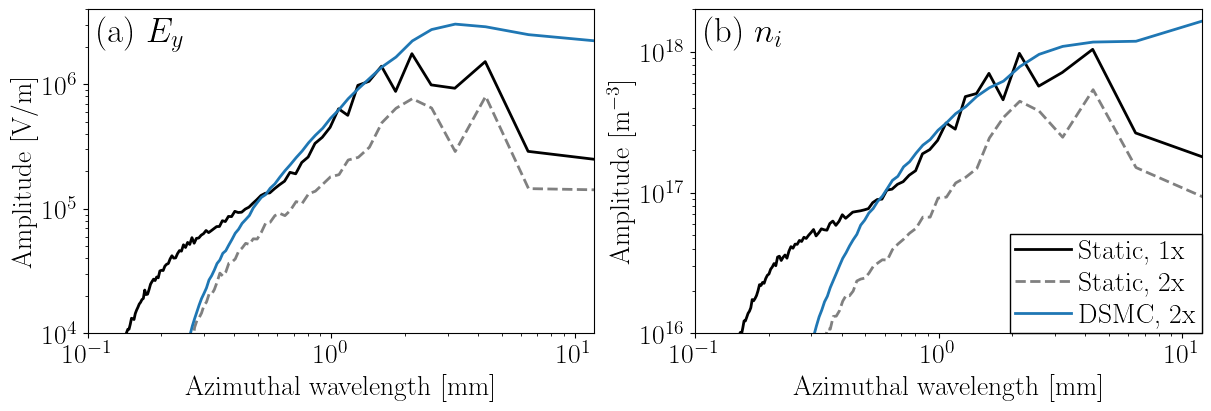

In [139]:
plot_k_spectrum(["Ez", "ni"], x = 1e-2)

In [136]:
def plot_freq_spectrum(fields, x):
    data_2x = extract_data_in_range(Path("../archive/base_2x_2000K_2/processed"), 50e-6, 200e-6, fields)
    data_noiz = extract_data_in_range(Path("../archive/base_1x_noneutrals/processed"), 12e-6, 20e-6, fields)
    data_noiz_2 = extract_data_in_range(Path("../archive/base_2x_noneutrals/processed"), 12e-6, 20e-6, fields)

    cases = [data_noiz, data_noiz_2, data_2x]
    colors = ["black", "gray", "tab:blue"]
    styles = ['solid', 'dashed', 'solid']
    names = ['Static, 1x', 'Static, 2x', 'DSMC, 2x']
    N = len(fields)

    fig, axes = plt.subplots(1,N, constrained_layout=True, figsize=(6*N,4))

    for (i, field) in enumerate(fields):
        ylim = (None, None)
        if field == "Ez":
            ylim = (6e4, 2e7)
            ylabel = "Amplitude [V/m]"
            annotation_args = dict(xy = (0.02, 0.98), va='top',)
        elif field == "ni":
            ylim = (4e16, 2e20)
            ylabel = "Amplitude [m$^{-3}$]"
            annotation_args = dict(xy = (0.98, 0.98), va = 'top', ha = 'right',)

        for (j, case) in enumerate(cases):
            spectrum = lib.frequency_spectrum(case, field)
            ax = axes[i]
            x_index = find_nearest(spectrum["x_m"], x)

            # Convert rad/s to Hz
            freq = spectrum["frequency"] / (2 * np.pi)
            
            amplitude = spectrum["amplitudes"][x_index]
            ind_max = np.argmax(amplitude)
            ax.plot(freq, amplitude, color = colors[j], linestyle = styles[j], label = names[j])
            if j == 0:
                ax.set(xscale = 'log', yscale = 'log', xlim = (1e4, 1e7), ylim=ylim, xlabel = "Azimuthal frequency [Hz]", ylabel = ylabel)
                ax.annotate(f"({LETTERS[i]}) {FIELD_TEX[field]}",  xycoords = 'axes fraction', fontsize=25, **annotation_args)
            if i == 0:
                ax.legend(labelspacing=0.25, loc = 'lower left')

    save_and_close(fig, f"freq_spectrum")

## Frequency spectrum

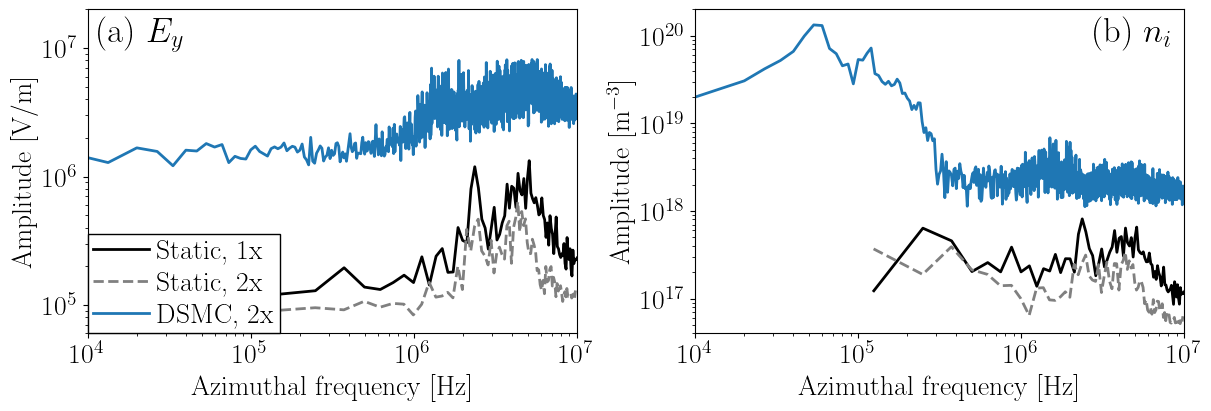

In [137]:
plot_freq_spectrum(["Ez", "ni"], x = 1e-2)

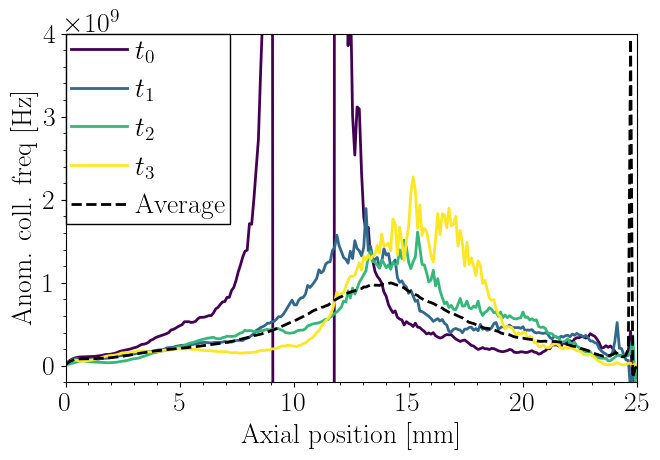

In [206]:
phase_ind = 0
data = extract_data_in_range(Path("../archive/base_2x_2000K_2/processed"), 100e-6, 130e-6, ["Ez", "ne", "uz_electrons"])
data_avg = extract_data_in_range(Path("../archive/base_2x_2000K_2/processed"), 150e-6, 200e-6, ["Ez", "ne", "uz_electrons"])
sample_rate = 1 / (data["t"][1] - data["t"][0])
t = data["t"] * 1e6
indices = [find_nearest(t, phase) for phase in phases]

fig, ax = plt.subplots(1,1, figsize = (7, 5))

R_anom = np.mean(compute_anomalous_force(data, 1e-6), axis = 1)
ne = np.mean(data["ne"], axis = 1)
uz_electrons = np.mean(data["uz_electrons"], axis = 1)
window = [-1, 0, 1]

for i, (ind, phase) in enumerate(zip(indices, phases)):
    _window = ind + window
    _R = np.mean(R_anom[ind + window], axis=0)
    _ne = np.mean(ne[ind + window], axis=0)
    _uz = np.mean(uz_electrons[ind+window], axis=0)
    nu_anom = _R / (lib.m_e * _ne * _uz)
    ax.plot(data["x"]*1000, nu_anom, color = colors[i], label = f"$t_{i}$")

R_mean = np.mean(compute_anomalous_force(data_avg, 1e-6), axis=(0,1))
ne_mean = np.mean(data_avg["ne"], axis = (0,1))
uz_mean = np.mean(data_avg["uz_electrons"], axis=(0,1))
nu_mean = np.mean(R_anom, axis=0) / (lib.m_e * ne_mean * uz_mean)
ax.plot(data["x"] * 1000, nu_mean, color = 'black', linestyle = 'dashed', label = 'Average')

ax.legend()
ax.set(xlim=(0,25), ylim=(-0.2e9, 4e9), xlabel=axis_label("x"), ylabel = "Anom. coll. freq [Hz]")
fig.tight_layout()
save_and_close(fig, "anom_coll_freq")